# Anomaly Detection (Air Handling Units) - Model Inferencing

This Jupyter notebook demonstrates how to use the SAS Event Stream Processing ESPPy module to perform anomaly detection with a model previously created and stored on an analytic store file.

Additional resources for this use case can be found at the SAS GitHub page for [Anomaly Detection in Air Handling Units](https://github.com/sassoftware/iot-anomaly-detection-hvac) including an example of deploying an offline model in SAS Event Stream Processing Studio.

### 0. Setup the Environment

First, import the necessary packages to run this notebook. Set the home directory, which tells the notebook where to save the model XML file.

In [1]:
import esppy
import ipywidgets as widgets
from esppy.espapi.visuals import Visuals
from inspect import getsource

import time
import datetime

%matplotlib inline
import pandas as pd

Use Pandas to read in the data.

In [2]:
ahu_data = pd.read_csv('/demo/Event_Stream_Processing/data/ahu_scr.csv', header=0)

Set the value of <code>display.image_scale</code> to 0.6. This value enables you to better visualize the project as you add more windows.

In [3]:
esppy.options.display.image_scale = 0.75

Next, establish a connection with the ESP server for the project and an additional one to be used by the PLOTLY graphic library APIs.

In [4]:
esp = esppy.ESP('http://localhost:5001')
conn = esp.createServerConnection(interval=0)

esp

ESP('http://localhost:5001')

### 1. Create a Project

Create a project using <code>esp.create_project</code>  and name it **proj**.

In [5]:
proj = esp.create_project('AHU_AnomalyDetection')

Now create a continuous query and call it <code>cq</code>. Add this query to the project. Continuous queries run automatically and periodically on streaming data.

To learn more about continuous queries in SAS ESP, see [Continuous Queries.](https://go.documentation.sas.com/?cdcId=espcdc&cdcVersion=6.2&docsetId=espstudio&docsetTarget=n05qoojb1v1ly3n1kkje39jmu7bb.htm&locale=en)

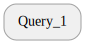

In [6]:
cq = esp.ContinuousQuery(name='Query_1')
proj.add_query(cq)

### 2. Create Project Windows
First, create a Source window and call it src_data. Source windows accept streaming data or raw data files. 
Create a schema that corresponds to **ahu_scr** data in the Source window. 

To read more about Source windows, see [Using Source Windows.](https://go.documentation.sas.com/?cdcId=espcdc&cdcVersion=6.2&docsetId=espcreatewindows&docsetTarget=p1h7eov9msvacmn1st88y7nlun1e.htm&locale=en)

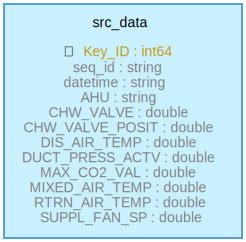

In [7]:
src = esp.SourceWindow(schema=('Key_ID*:int64', 'seq_id:string','datetime:string',
                                         'AHU:string','CHW_VALVE:double', 'CHW_VALVE_POSIT:double', 'DIS_AIR_TEMP:double',
                                         'DUCT_PRESS_ACTV:double','MAX_CO2_VAL:double','MIXED_AIR_TEMP:double','RTRN_AIR_TEMP:double',
                                         'SUPPL_FAN_SP:double'),
                       index_type='empty', insert_only=True, name='src_data')

cq.add_window(src)
#cq

Create a Source window to read in the model data.

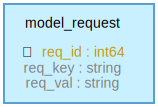

In [8]:
model_request=esp.SourceWindow(schema=('req_id*:int64', 'req_key:string', 'req_val:string'),
                                 index_type='empty', insert_only=True, name='model_request')
cq.add_window(model_request)
#cq

Next, create a window to read the model that is stored in the analytic store file. Call it model_reader.

To read more about Model Reader windows, see [Using Model Reader Windows.](https://go.documentation.sas.com/?cdcId=espcdc&cdcVersion=6.2&docsetId=espcreatewindows&docsetTarget=n0jsa0omxyf6m4n1ava0ekx1bli4.htm&locale=en)

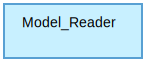

In [9]:
model_reader = esp.ModelReaderWindow(name='Model_Reader', model_type="astore")
cq.add_window(model_reader)
#cq

Create a Score window that uses the offline analytic store model to score the **ahu_scr** data.

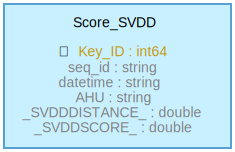

In [10]:
score_svdd = esp.ScoreWindow(name='Score_SVDD',
                                 schema=('Key_ID*:int64', 'seq_id:string','datetime:string',  'AHU:string',
                                         '_SVDDDISTANCE_:double',
                                         '_SVDDSCORE_:double'))
score_svdd.add_connector('fs', conn_name='sub', conn_type='subscribe', 
                         properties={'type':'sub', 'fstype':'csv', 'fsname': '/user/my_data/svdd_out.csv', 'snapshot':True,'header':'full'})
score_svdd.add_offline_model(model_type='astore')
cq.add_window(score_svdd)
#cq

After the windows have been created and added to the project, you can connect them by creating edges. To read more about connectors, see [Overview to Connectors.](https://go.documentation.sas.com/?cdcId=espcdc&cdcVersion=6.2&docsetId=espca&docsetTarget=p1nhdjrc9n0nnmn1fxqnyc0nihzz.htm&locale=en)

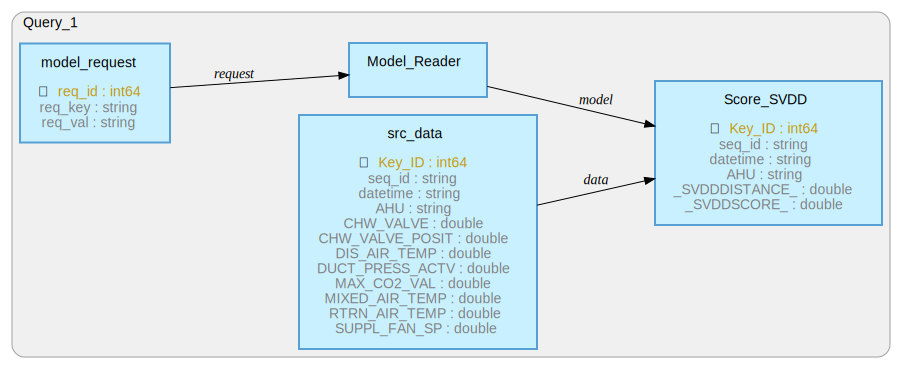

In [11]:
src.add_target(score_svdd, role='data')
model_request.add_target(model_reader, role='request')
model_reader.add_target(score_svdd, role='model')
cq.to_graph(schema=True)

### 3. Save Project to XML and Load It into the ESP Server

You have the option of saving the project that you created to an XML file. Here, save the 'AHUAnomalyDetection.xml' to the /shared/code folder. 

In [12]:
proj.save_xml('/user/my_code/ahu_anomaly_detection.xml')

Next, load the project to the ESP server using <code>esp.load_project</code> and save the project code to /shared/code folder.

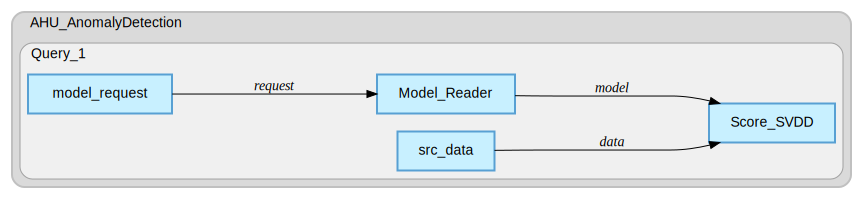

In [13]:
esp.load_project(proj)

### 4. Subscribe to the Project Windows 

Subscribe to the project windows in order to receive output from them.

In [14]:
src.subscribe()
model_request.subscribe()
score_svdd.subscribe()
model_reader.subscribe()

ahuScoring = conn.getEventCollection("AHU_AnomalyDetection/Query_1/Score_SVDD")

### 5. Publish Offline Model and Load the Model with Data for Scoring

Create a publisher to publish the model to the score_svdd windows so that the project knows which model to use.

This step takes approximately 20 seconds to complete. The instruction <code>time.sleep(20)</code> is included to allow for the connection to be made before sending images to the server.

In [15]:
pubmodel = model_request.create_publisher(blocksize=1, rate=0, pause=0,
                                       opcode='insert', format='csv')
pubmodel.send('i,n,1,"action","load"\n')
pubmodel.send('i,n,2,"type","astore"\n')
pubmodel.send('i,n,3,"reference","/demo/Event_Stream_Processing/data/ahu_svdd.astore"\n')

pubmodel.send('i,n,4,,\n')
pubmodel.close()

time.sleep(5)

Assign a variable to your raw data variable.

In [16]:
mydata= ahu_data
mydata.index.name='Key_ID'
mydata

,seq_id,datetime,AHU,CHW_VALVE,CHW_VALVE_POSIT,DIS_AIR_TEMP,DUCT_PRESS_ACTV,MAX_CO2_VAL,MIXED_AIR_TEMP,RTRN_AIR_TEMP,SUPPL_FAN_SP
Key_ID,,,,,,,,,,,
0,22556,08JAN15:08:45:00,AHU_5_1,40.935,33.6570,61.1989,0.8069,573.6057,73.8902,75.2763,16.71
1,22557,08JAN15:09:00:00,AHU_5_1,41.810,46.8994,59.0927,0.8149,659.0546,73.0801,75.0063,16.71
2,22558,08JAN15:09:15:00,AHU_5_1,31.075,33.5268,59.3627,0.8109,654.7821,73.1701,74.3582,16.71
3,22559,08JAN15:09:30:00,AHU_5_1,45.105,43.8167,60.4609,0.8230,693.8445,73.4402,73.9982,16.71
4,22560,08JAN15:09:45:00,AHU_5_1,36.975,38.9540,59.2727,0.7748,1004.5130,73.6202,73.5302,18.60
...,...,...,...,...,...,...,...,...,...,...,...
20027,42583,31MAR15:22:53:00,AHU_5_2,0.000,1.7452,71.1915,0.0000,0.0000,67.7516,72.9721,0.00
20028,42584,31MAR15:23:08:00,AHU_5_2,0.000,1.7452,71.4616,0.0000,0.0000,68.0396,73.0801,0.00
20029,42585,31MAR15:23:23:00,AHU_5_2,0.000,1.7452,71.7496,0.0000,0.0000,68.3996,73.0801,0.00


Use the <code>publish_events()</code> method to publish data to the data events Source window of the model. Use the <code>subscribe()</code> method to create a DataFrame for the Source window as the SourceWindow’s <code>data</code> attribute. After you create the DataFrame in the <code>data</code> attribute of a window object, you can use Pandas DataFrame methods on the window object as if it were a DataFrame:

In [17]:
src.publish_events(mydata, pause=1000)
src.subscribe()
src.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   seq_id           0 non-null      object 
 1   datetime         0 non-null      object 
 2   AHU              0 non-null      object 
 3   CHW_VALVE        0 non-null      float64
 4   CHW_VALVE_POSIT  0 non-null      float64
 5   DIS_AIR_TEMP     0 non-null      float64
 6   DUCT_PRESS_ACTV  0 non-null      float64
 7   MAX_CO2_VAL      0 non-null      float64
 8   MIXED_AIR_TEMP   0 non-null      float64
 9   RTRN_AIR_TEMP    0 non-null      float64
 10  SUPPL_FAN_SP     0 non-null      float64
dtypes: float64(8), object(3)
memory usage: 0.0+ bytes


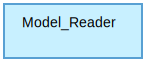

In [18]:
model_reader

## 6. Display the Scoring Results 

Show the scoring results by subscribing to the 'score_svdd' window output.

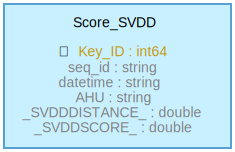

In [19]:
score_svdd

Optionally, use the interface with the PLOTLY graphic library to show the results in a customized format.

In [20]:
conn = esp.createServerConnection()

sf_input = conn.getEventStream("AHU_AnomalyDetection/Query_1/Score_SVDD",maxevents=20)

visuals = Visuals(colormap="sas_corporate",border="1px solid blue")

table = visuals.createTable(sf_input,values=["Key_ID","_SVDDDISTANCE_","_SVDDSCORE_"],title="Values Generated",
                            show_controls=True, width="35%")
chart=visuals.createBubbleChart(sf_input,y="_SVDDDISTANCE_", size="_SVDDDISTANCE_",color="_SVDDSCORE_",title="SVDD Distance")
widgets.HBox([table,chart])

In [21]:
# proj.delete()